In [1]:
using Bloqade

In [2]:
nsites = 12; # 12-site ring
unit_disk_radius = 6.9 # Distance between nearest-neighbor atoms, in microns; R_min

R = unit_disk_radius / (2 * sin(2 * pi / (nsites) / 2)) # Radius of the circle, using a little trigonometry; it is also the next-nearest neighbor distance, R_max.
pos = [(R * sin(i * 2 * pi / (nsites)), R * cos(i * 2 * pi / (nsites))) for i in 1:nsites] # Positions of each atom
atoms = AtomList(pos); # Define the atom positions as an AtomList.

blockade_radius = sqrt(unit_disk_radius * R);  # R_b = \sqrt{R_min R_max}

In [3]:
C6 = 2π * 862690;
Ω = C6 / blockade_radius^6
h = rydberg_h(atoms; Ω = Ω);

In [4]:
subspace_radius = unit_disk_radius # R_s

init_state = zero_state(nsites) # Define the initial state in the full space.
space = blockade_subspace(atoms, subspace_radius) # Compute the blockade subspace with R_s.
init_state2 = zero_state(space); # Define the initial state in the blockade subspace.

In [5]:
Tmax = 6.0
nsteps = 2001
times = LinRange(0, Tmax, nsteps)
dt = Tmax / (nsteps - 1)

prob = SchrodingerProblem(init_state, Tmax, h, dt = dt, adaptive = false);
integrator = init(prob, Vern8());

densities = [] # Time evolve the system in the full space
for _ in TimeChoiceIterator(integrator, 0.0:dt:Tmax)
    push!(densities, rydberg_density(init_state, 1))
end

prob2 = SchrodingerProblem(init_state2, Tmax, h, dt = dt, adaptive = false);
integrator2 = init(prob2, Vern8());

densities2 = [] # Time evolve the system in the subspace
for _ in TimeChoiceIterator(integrator2, 0.0:dt:Tmax)
    push!(densities2, rydberg_density(init_state2, 1))
end



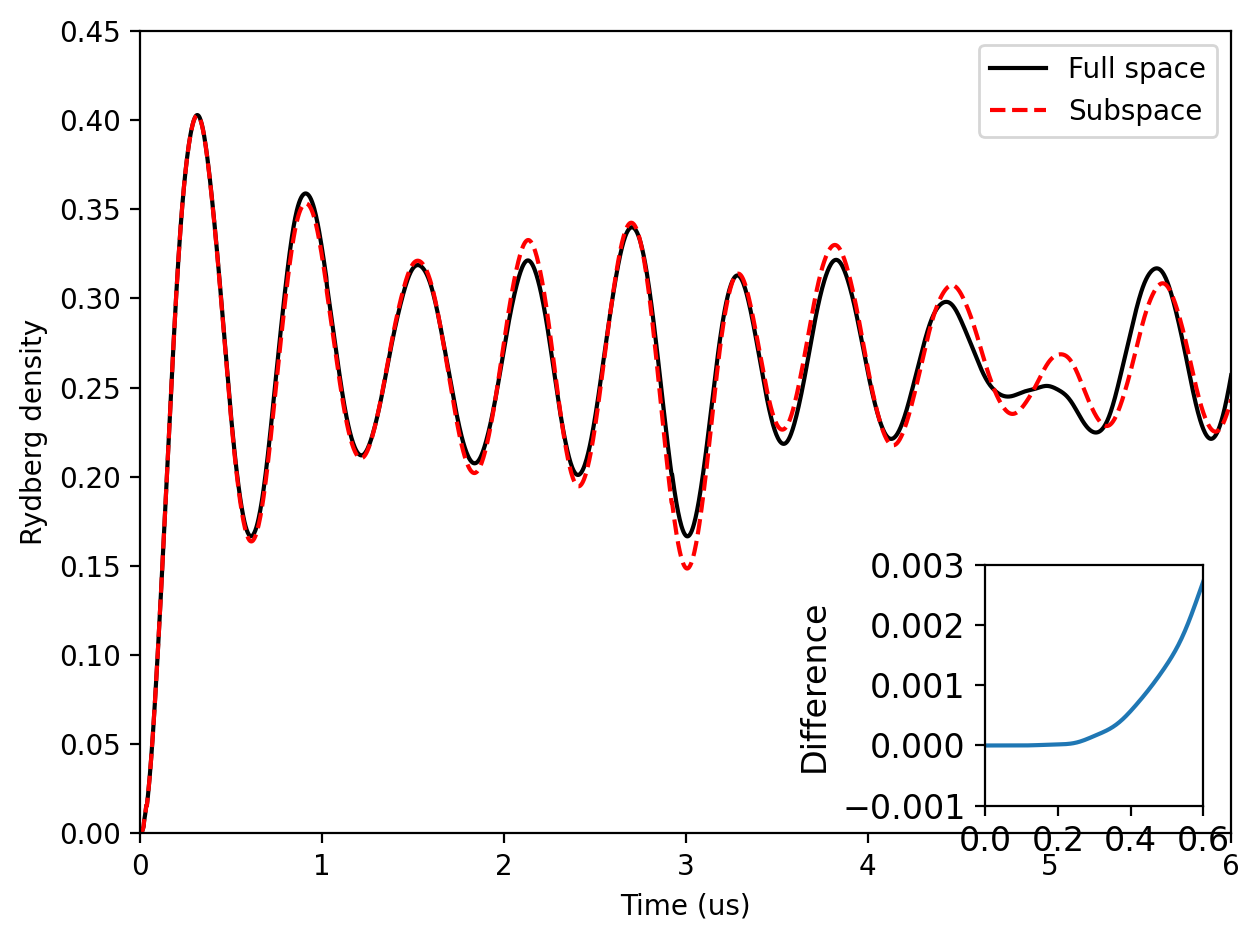

In [7]:
using PythonCall # Use matplotlib to generate plots
matplotlib = pyimport("matplotlib")
plt = pyimport("matplotlib.pyplot")

fig1, ax = plt.subplots()
plt.plot(times, real(densities), "k", label = "Full space")
plt.plot(times, real(densities2), "r--", label = "Subspace")
ax.axis([0, Tmax, 0, 0.45])
plt.xlabel("Time (us)")
plt.ylabel("Rydberg density")
plt.tight_layout()
plt.legend()

inset_axes = pyimport("mpl_toolkits.axes_grid1.inset_locator")
ax2 = inset_axes.inset_axes(ax, width = "20%", height = "30%", loc = "lower right", borderpad = 1)
plt.plot(times, real(densities - densities2))
plt.axis([0, 0.5, -0.001, 0.003])
plt.ylabel("Difference", fontsize = 12)
plt.yticks(LinRange(-0.001, 0.003, 5), fontsize = 12);
plt.xticks([0, 0.2, 0.4, 0.6], fontsize = 12)
fig1